# Assignment 2 -- ML4F 2021 -- Group 04

David Landveld - 2742120 - d.j.f.landveld@student.vu.nl

Mark de Kwaasteniet - 2649271 - m.g.de.kwaasteniet@student.vu.nl

Marc Peter van Gils - 2703225 - m.p.van.gils@student.vu.nl

## Instructions

* Each group submits _only one_ notebook via canvas on the assignment page. 
* The notebook should be named `assignment2_groupXX.ipynb` where `XX` is your group number,  
e.g. for group 3 this will be `assignment2_group03.ipynb`.
* The notebook should run without raising any errors. 
* We recommend keeping the folder structure
```
assignment/
    data/
    lib/
    assignment2_groupXX.ipynb
```
* We strongly recommend git, as you are encouraged to collaborate and split up the work and maybe even start independently. To see how to set up your own repo for your group, see `L2-git-slides.pdf`.
* Do not spend time on optimizing the speed of your code. 
* We strongly encourage you to experiment, try different approaches and combinations and get to know the problem from alternative angles. But the final notebook should only contain the necessary results for grading.

In [1]:
%reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from math import sqrt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
import sklearn.metrics as sm

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Introduction

The Paycheck Protection Program (PPP) gives support to companies who are negatively impacted by Covid-19 to pay their employees. Many businesses have been affected and the money was limited. This means the PPP cannot give all the companies money. The dataset provided contains the loans to different companies. It also contains the probability of default (`ProbabilityDefault`) as estimated by the loan officer.

Let's load and have a look at the data.

In [2]:
path = os.path.join('data','loans.xlsx')

df_data = pd.read_excel(path)

In [3]:
df_data.head(5)

LoanAmount         City State    Zip  NAICSCode  \
0      20800        EAGLE    ID  83616   531210.0   
1      80000       HAYDEN    ID  83835   722511.0   
2      75500  IDAHO FALLS    ID  83401   811121.0   
3     133500   POST FALLS    ID  83854   722211.0   
4       8187        RIGBY    ID  83442   327991.0   

                      BusinessType RaceEthnicity        Gender      Veteran  \
0  Limited  Liability Company(LLC)    Unanswered    Unanswered   Unanswered   
1                      Corporation         Asian  Female Owned   Unanswered   
2         Subchapter S Corporation         White    Male Owned  Non-Veteran   
3  Limited  Liability Company(LLC)         White    Unanswered   Unanswered   
4              Sole Proprietorship         White    Male Owned  Non-Veteran   

  NonProfit  JobsRetained         DateApproved                 Lender  \
0       NaN           0.0  2020-07-04 00:00:00  Washington Trust Bank   
1       NaN          24.0           04/15/2020           Glacier Bank   
2       NaN           7.0  2020-10-04 00:00:00          Bank of Idaho   
3       NaN          26.0           04/13/2020  First Interstate Bank   
4       NaN           1.0  2020-05-05 00:00:00            Beehive FCU   

        CD  AgeLoan  ProbabilityDefault  
0  ID - 01      117            1.250967  
1  ID - 01      230            6.033691  
2  ID - 02      236            2.334621  
3  ID - 01      240            9.567953  
4  ID - 02       51            1.462785

##### Interpretation of Dataframe
We see that the dataframe contains both numerical and categorical variables. Additionally, the columns have missing values, incorrect values/strings and different notation methods.

We will not yet tackle the missing values. These missing values will remain NaN, since we will determine how we are going to impute them based on the distributions of the data.

We locate the incorrect values by looking at the different datatypes and unique values. 
- Here we already see that the variable 'LoanAmount' is an object when in fact it should be a numerical value. This indicates that there might be some incorrect inputs in this variable. Further investigation has led us to believe that some values contain a comma which converts them into an object instead of a string.

By looking at the describe function, we also find incorrect values by looking at min of max values. To see if there are large outliers that might not be possible.
- In this case we find that there are high (above 100%) and negative probability of defaults present in the dataset. Both are not possible since the probability of default cannot be higher than 100% and it cannot be negative. Therefore, before transforming the data, we will manipulate this column and set the incorrect values equal to NaN. Just like before we let these incorrect values be NaN and check the distributions before imputing them. 

Lastly, we find that the 'DateApproved' variable has different input methods. Some strings contain the month/day/year and some strings contain the year-month-day and time. To make the data uniform, we transform this variable into a consistent Date variable.

In [4]:
#Remove the comma's from the strings in the LoanAmount column.
df_data['LoanAmount'] = df_data['LoanAmount'].replace(',', '.', regex=True).astype(float)

#Make the DateApproved Variable uniform over the whole column
df_data.DateApproved = pd.to_datetime(df_data['DateApproved']).dt.strftime('%Y-%m-%d')
df_data.DateApproved = df_data['DateApproved'].apply(pd.to_datetime)

#Convert the JobsRetained variable from Float to Int.
#df_data['JobsRetained'] = df_data['JobsRetained'].fillna(df_data['JobsRetained'].mean()).astype(int)
#df_data['JobsRetained'] = df_data['JobsRetained'].astype(int)
#col=np.array(df_data['JobsRetained'], np.int16) 
#df_data['JobsRetained']=col

In [5]:
Negative = 0
Maximum_perc = 100 #Or 100%? --> 80% gives a much better distribution, making me think that there is one 100% probability that we can consider an outlier
#df_data['ProbabilityDefault'][(df_data['ProbabilityDefault'] < Negative) | (df_data['ProbabilityDefault'] > Maximum_perc)] = np.nan

In [6]:
df_data.dtypes

LoanAmount                   float64
City                          object
State                         object
Zip                            int64
NAICSCode                    float64
BusinessType                  object
RaceEthnicity                 object
Gender                        object
Veteran                       object
NonProfit                     object
JobsRetained                 float64
DateApproved          datetime64[ns]
Lender                        object
CD                            object
AgeLoan                        int64
ProbabilityDefault           float64
dtype: object

# Question 1
(12 points)

### *Use the methods discussed so far to preprocess the data. Make some descriptive statistics and histograms etc to find out more about the distributions of the data. Are there NaNs, outliers etc? Then choose what preprocessing to apply and clearly explain your choices.*

We've already manipulated some of the variables in the dataframe according to the Dataframe and its form.

Now we will again look at all the different datatypes to select split the numerical variables from the categorical variables and to determine what categorical variables we would like to include in our model. 
- In the DataFrame (after manipulation) we find 5 numerical variables, excluding the ProbabilityDefault (target). We will use only three numerical variables as features, since the other two numerical variables are Zip and NAICSCode, which are numerical values that represent a category. I.e., the place of the company and the industry the company is operating in. 
- In the DataFrame we find 10 categorical variables. However, not all of these variables are suited to be included in the model as categorical variable because there might be too many or too few categories to choose from. We inspect the number of categories by looping over each categorical variable and printing the number of unique strings in this column.

Categorical results:
- City, State, NAICSCode, Lender are the columns that will be dropped from the feature set, because they have too many categories (>100) or too few categories (<2). 
### ZIP as well, except for question 2
- The rest of the categorical variables will be stored in a list and will be transformed in to features.

We transform the categorical variables into features by creating dummy variables for every category in that variable (excluding one dummy due to multicollinearity problems). This creates a total dataframe of 105 columns.


In [7]:
target_name = 'ProbabilityDefault'

# `sr_` prefix stands for a pandas Series
sr_targets = df_data.loc[:,target_name]

# The features are considered all the dataframe variables including the ProbabilityDefault for Question 2
sr_features = df_data.copy()

In [8]:
# Drop the variables that have too many or too few categories
drop_columns = ['NAICSCode', 'State', 'City', 'Lender'] #Zip?
sr_features.drop(drop_columns, inplace=True, axis=1)

#### Distribution of the target
By creating a histogram of the target `ProbabilityDefault`, we can see that the target has most of its probabilities around 0%-20%. Still there are some extreme outliers of 500% which we have touched upon at the desciptive statistics.

In [9]:
# sr_targets.hist(color = "g")
# plt.title("Histogram Target")
# plt.xlabel("Probability of Default")
# plt.ylabel("Number of Observations")
# plt.show()

When looking at boxplots of all the features/target, we primarily see that the following features/target have a lot of outliers: `ProbabilityDefault`, `JobsRetained` and `Zip`. We will process these features by clipping the outliers based on 4 standard deviations. 

However, notice that we will also clip the `Zip` distribution for usage in Question 2. However, `Zip` is a categorical feature with numerical features, therefore removing outliers in this feature can be incorrect.

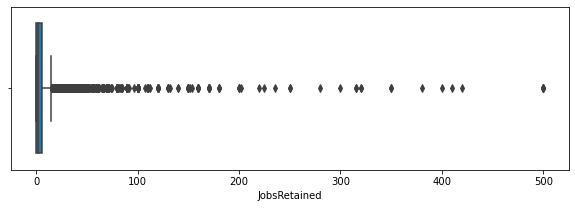

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3)
sns.boxplot(x=sr_features['JobsRetained'])
plt.show()

In [11]:
# Create dummy features for every category.
list_categories = ['BusinessType','RaceEthnicity','Gender','Veteran','NonProfit', 'CD', 'DateApproved'] 
sr_features = pd.get_dummies(sr_features, columns = list_categories, drop_first=True)

When we again look at the features in the dataset, we see that most of them are dummy variables which represent categories. We still have three numerical features that we might want to transform. Looking at the distributions, we see that both LoanAmount and JobsRetained are features that have a positive skewness. In this case a log transformation can be a usefull transformation method, creating a more normal distribution. This will automatically scale the features as well. 

However, we only log transform the LoanAmount feature. This is because the JobsRetained features contains some zero values that could have explanatory value, we won't use a log transformation on this feature. A log transformation would return this zero value to infinity, meaning that we would have to impute this zero values after the transformation. We don't want to do this since the zero's could be meaningfull to the ProbabilityDefault target. 

After the Log Transformation of the LoanAmount, the three numerical features: LoanAmount, JobsRetained and AgeLoan are not yet in the same scale. Therefore, we also scale the features using a standardization method.

#### Robust Standardization
By standardizing, every feature will have similar scales making it easier to compare the features. Furthermore, after the standardization, a certain percentile of the data can be easily removed using the standard deviation that is calculated. We choose standardization over normalization, because standardization provides more usefull info about the outliers in the dataframe (which is asked in the question).
 
In our case we use the RobustScaler of scikit, since it is more robust against outliers compared to the StandardScaler, meaning it scales the features according to the InterQuartileRange (0.25|0.75) of that feature. 

However, since this method is not immune to outliers, we still find some outliers in the histograms after the standardization. We want remove these outliers to improve the generalisability of the logistic model that we are specifying later on. 

We clip these outliers ourselves using 4 standard deviations relative to every feature. Meaning we replace all the values that are outside 0.1% and 99.99% of the distribution of a certain feature by NaN. We set them to NaN instead of winsorizing, to prevent certain features from having a large number of -4 and/or 4 values.

In [12]:
# LOG -LoanAmount
sr_features.LoanAmount = (np.log(sr_features.LoanAmount)).replace(-np.inf, np.nan)

In [13]:
STD_OUTLIER = 4

sr_features_std = sr_features.copy()

#Standardize using RobustScaler
sr_features_std[sr_features_std.columns] = RobustScaler().fit_transform(sr_features_std[sr_features_std.columns])

#Convert values in the dataframe with a z-score < -4 or > 4 to NaN
sr_features_std[(sr_features_std < -STD_OUTLIER) | (sr_features_std > STD_OUTLIER)] = np.nan

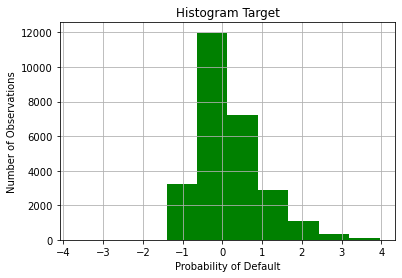

In [14]:
sr_features_std['ProbabilityDefault'].hist(color = "g")
plt.title("Histogram Target")
plt.xlabel("Probability of Default")
plt.ylabel("Number of Observations")
plt.show()

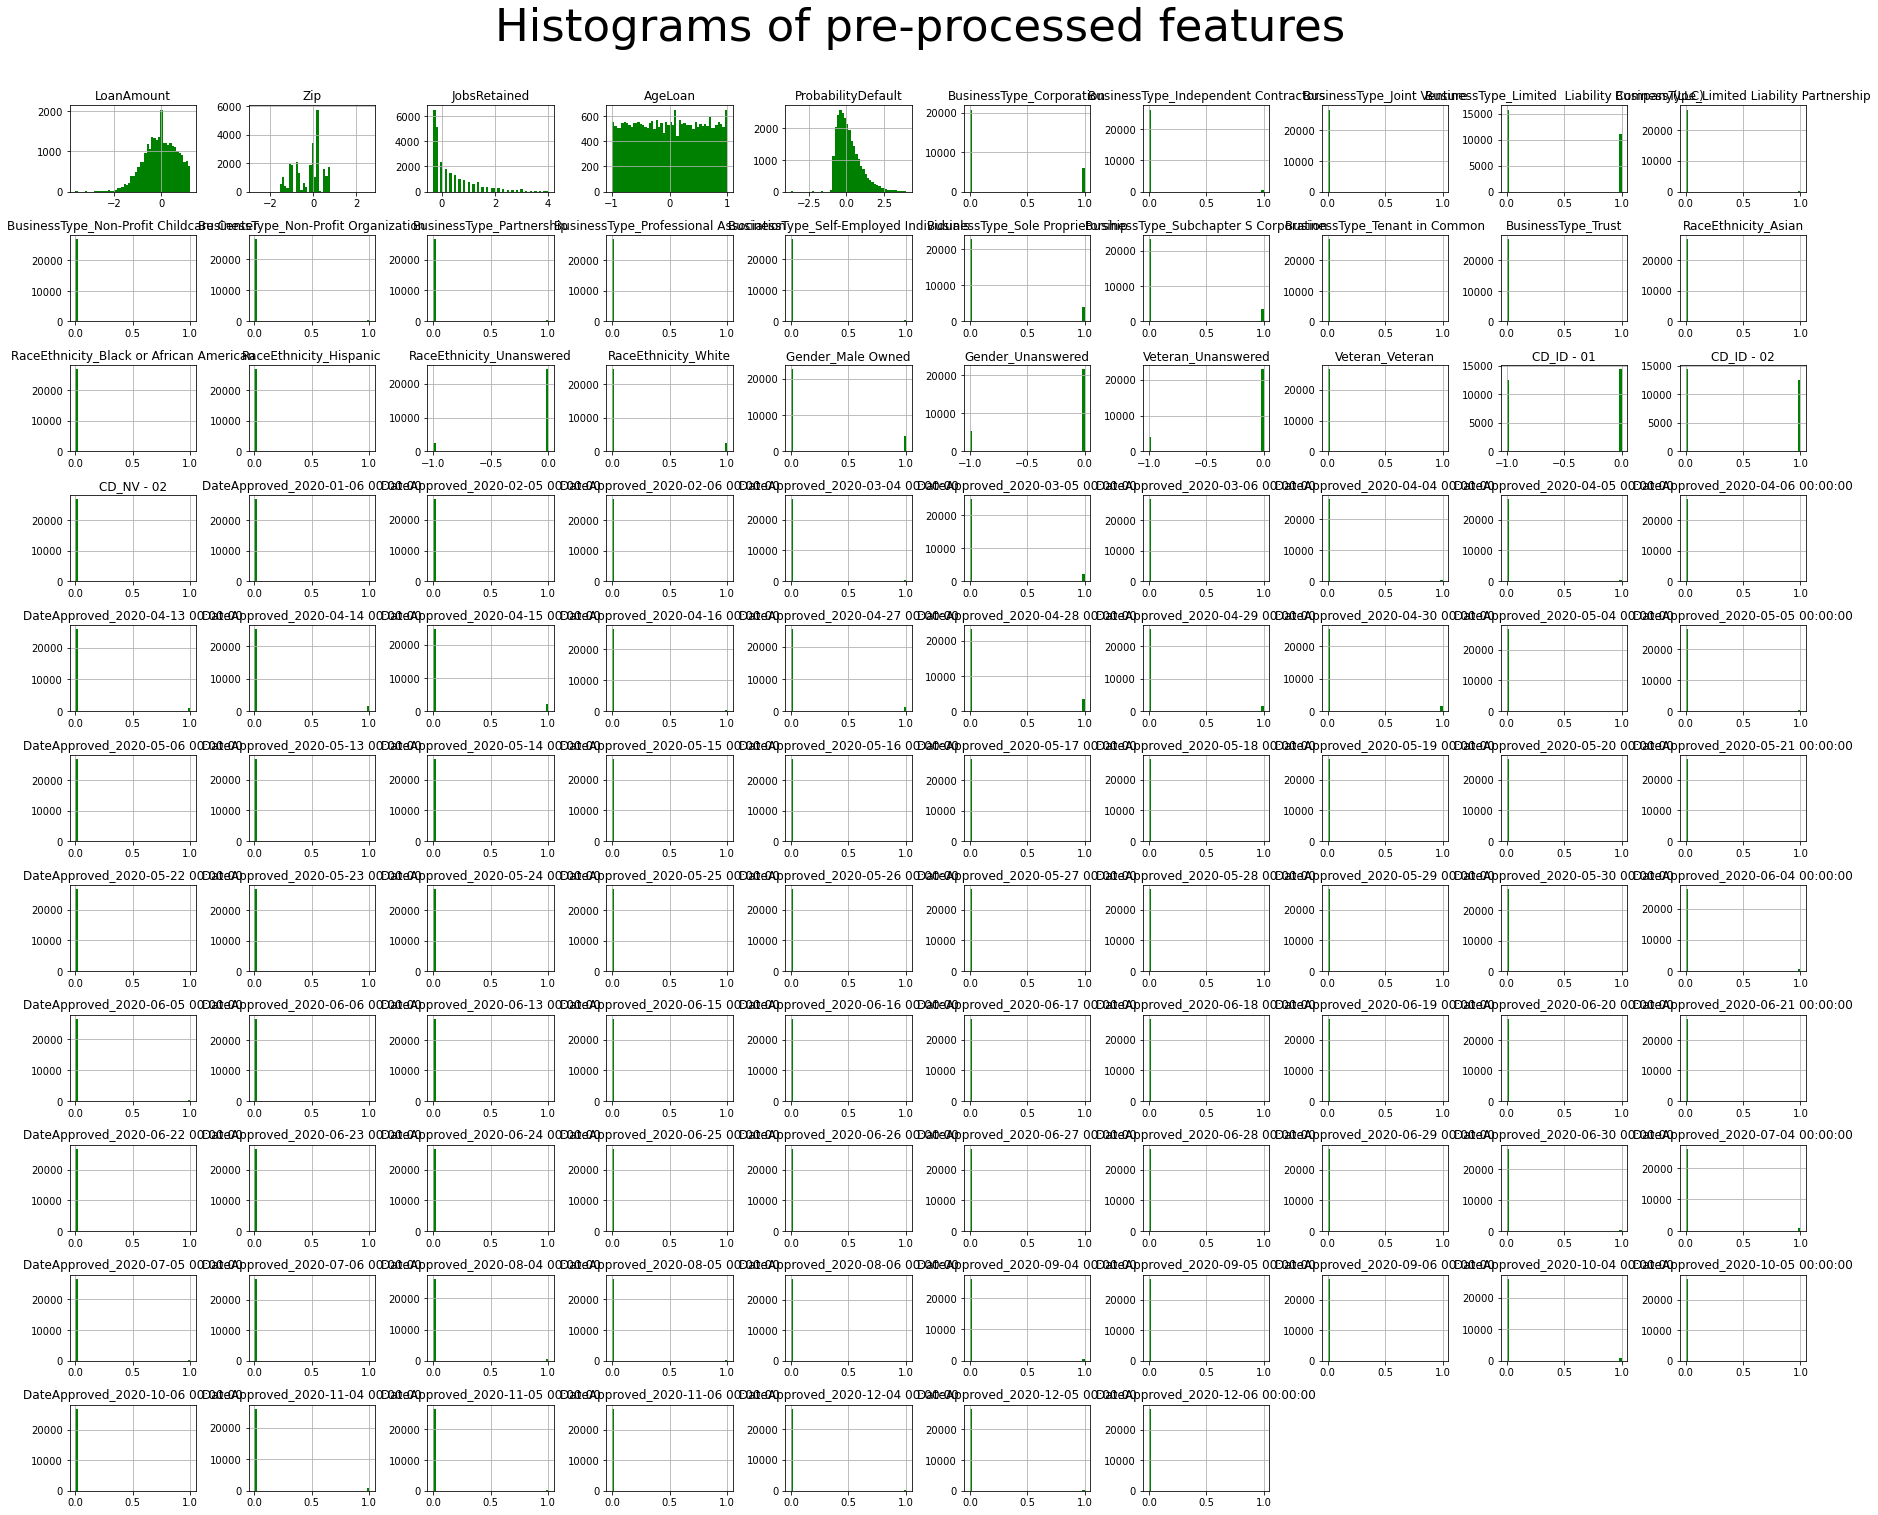

In [15]:
sr_features_std.hist(bins=50, figsize=(25, 20), color = "g")
plt.tight_layout()   

plt.suptitle('Histograms of pre-processed features', x=0.5, y=1.05, ha='center', fontsize='45')
plt.show()

Here we see that the distribution of LoanAmount has drastically changed into a more normal distribution. We only standardized the other features and removed the outliers. However, since there weren't a lot of features with outliers (only JobsRetained had some outliers), the other 104 distributions are similar to the distributions before the standardization. 

VALUES OF ZIP

# Question 2
(22 points)

### *Explain what a k-means model is.*

A K-Means model is a machine learning algorithm that tries to classify unlabeled data. It is an unsupervised method to predict/find groups (clusters) within the data. The algorithm identifies a number (k) of so-called centroids which are centers of clusters of data. It starts by picking random centroids and, since the identification process is iterative, it only stops when the clustering is a success (there is no better position for the centroids) or when the maximum number of iterations is reached. The performance metric of a k-means model is inertia which is the mean squared distance to the closest centroid. Together with the silhouette, calculated by dividing (b-a) with max(a,b) (where a is the mean intra-cluster distance and b is the mean distance to the next cluster), the right number of clusters can be determined.


### *Estimate a k-means model with 3 clusters for the variables `LoanAmount`, `Zip`, `ProbabilityDefault` and `AgeLoan`.*

In [27]:
columns_interest = ['LoanAmount', 'Zip', 'AgeLoan', 'ProbabilityDefault']
df_kmeans = sr_features_std.copy()
df_kmeans = df_kmeans[columns_interest]

Since KMeans uses a distance-based measurements to determine the similarity between data points, we will work with standardized data to have a mean of zero and a standard deviation of one. Since the target (ProbabilityDefault) hasn't been standardized, we standardize this target first and then attach it to the df. 

In [28]:
print(df_kmeans.isna().sum())
df_kmeans = df_kmeans.dropna()

LoanAmount             0
Zip                    4
AgeLoan                0
ProbabilityDefault    32
dtype: int64


Dropping NaN due to low amount relative to total

In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_kmeans)
y_kmeans = kmeans.predict(df_kmeans)

In [30]:
labels_group=['Low', 'Average', 'High']
df_kmeans['default_group'] = pd.cut(df_kmeans['ProbabilityDefault'], 3, labels=labels_group)

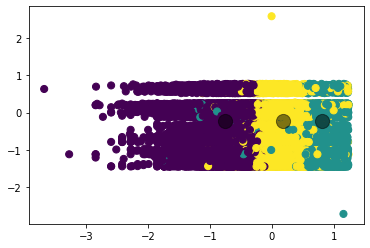

In [31]:
plt.scatter(df_kmeans.iloc[:, 0], df_kmeans.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()

### *Determine with the elbow method with inertia what the right number of clusters is. Please plot the inertia and explain your choice of clusters.*

In [32]:
#this loop will fit the k-means algorithm to our data and 
#second we will compute the within cluster sum of squares and #appended to our wcss list.
wcss=[]

for i in range(1,11): 
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_kmeans)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


ValueError: could not convert string to float: 'Average'

### Score elbow berekenen

In [33]:
# from kneed import KneeLocator
# kl = kneeLocator(range(1,11),inertia_score

### *Do the same but this time using the silhouette score. Compare both. Would you now reconsider your choice of the previous question?*

In [34]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

#### Silhouette Diagram

#### Silhouette Score Graph

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

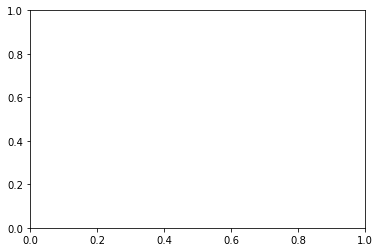

In [35]:
plt.plot(range_n_clusters,silhouette_scores)
plt.title('The Silhouette Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks([2,3,4,5,6])
plt.show()

#### Silhouette Diagram

Uitleg geven over de toevoeging van Silhouette Diagram ten opzicht van de score graph van silhouette diagram.

ValueError: could not convert string to float: 'Average'

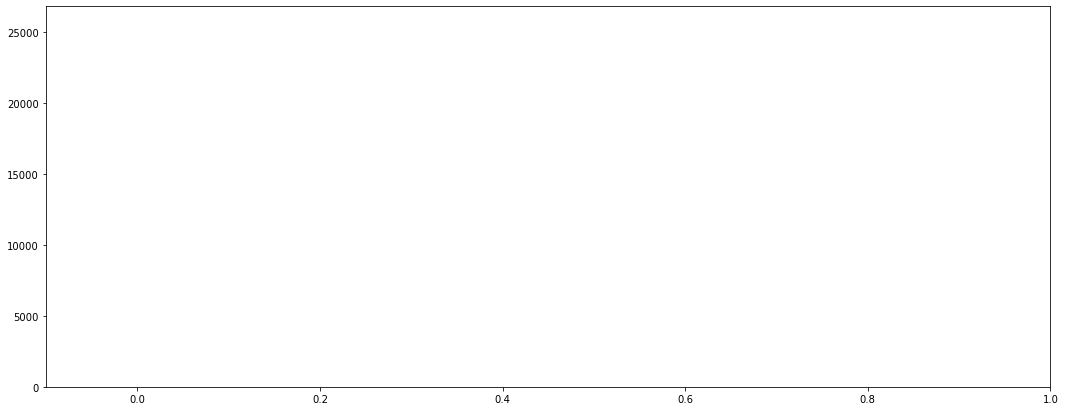

In [36]:
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_scores = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df_kmeans) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_kmeans)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_kmeans, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_kmeans, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

## Conclusie van Question 2 toevoegen.

# Question 3

(22 points)

### *Mention one advantage and one disadvantage of using Principal Component Analysis (PCA).*

#### Advantage
Principal Component Analysis is an effective method to create explanatory features in the dataset that are uncorrelated. By scaling the dimensions of the data to a certain amount (k), the analysis will create new features which are a combination of the existing features in the dataset. Therefore, the advantage of PCA that it is a very effective method to reduce the number of features in a model. Thus creating a more parsimonious model with independent principial components and improved performance. 
#### Disadvantage
Since Principal Component Analysis creates futures out of the original features from the dataset, it is much harder to interpret the PCA features. Because the new features consist of a certain combination of initial variables, the first PCA feature could be based on 10% of all the initial features, making it very complicated to interpret this feature.

### *Reduce the dataset to two dimensions with PCA and make a clear plot. Make sure to label all the important information.*

In [ ]:
import matplotlib.ticker as ticker

sklearn.impute.SimpleImputer use to impute the mean. 

In [ ]:
#extract the target (standardized) from the total dataframe.
sr_targets_std = pd.DataFrame(sr_features_std.loc[:,target_name])
sr_features_std = sr_features_std.drop([target_name],axis=1)

#differtiate between categorical and numerical features
list_num = ['LoanAmount', 'JobsRetained', 'AgeLoan']
sr_features_cat_std = sr_features_std.drop(list_num, axis=1)
sr_features_num_std = sr_features_std[list_num]

In [ ]:
sr_targets_std.dtypes

ProbabilityDefault    float64
dtype: object

In order for us to be able to use the PCA future creation method, we have to deal with the NaN values in the 'sr_features_num_std' DataFrame. We are imputing the data with the mean in order to not skew the pre-PCA features. We use scikit learns impute module. 

In [ ]:
from sklearn.decomposition import PCA
sr_features_num_std = sr_features_num_std.fillna(sr_features_num_std.mean())

NUMBER_COMPONENTS = 2

pca = PCA(n_components=NUMBER_COMPONENTS)
df_pca = pca.fit_transform(sr_features_num_std)

We can pre-visualise our PCA components and the explained variance ratio's by making a bar plot, that shows the added Explained Variance Ratio at a given number of principal components. In the same plot we also make a step plot that shows the Cumulative Explained Variance Ratio. 

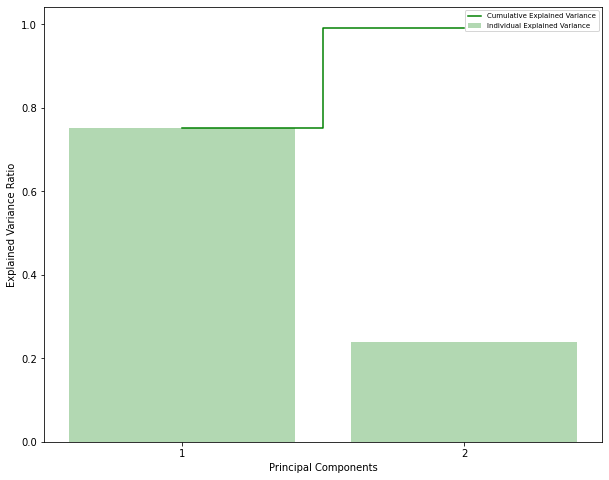

In [ ]:
plt.figure(figsize=(10, 8))
plt.bar(range(1,NUMBER_COMPONENTS+1), pca.explained_variance_ratio_, alpha=0.3, label='Individual Explained Variance', color = "g")
plt.step(range(1,NUMBER_COMPONENTS+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative Explained Variance', color = "g")
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend(fontsize='x-small')
plt.xticks([1,2])

plt.show()

### Interpretation

So far we see that choosing two Principal Components will have a Cumulative Explained Variance Ratio of roughly 100%. To visualise the PCA method's created features, see the PCA and TSNE comparison figure below. 

### *This time reduce the dataset to two dimensions with t-SNE and make a clear plot.*

Below, we create and fit the TSNE features. 

In [ ]:
from sklearn.manifold import TSNE
features_embedded = TSNE(n_components=2, perplexity=40, n_iter=300).fit_transform(sr_features_num_std)

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In order to be able to clearly see which groups/clusters are formed by both methods, we label the 'ProbabilityDefault' Target Variable. We create seven labels, ranging from extremely low to extremely high. We do this by dividing the data in seven equal parts. 

In [ ]:
labels_group=['Extremely Low','Very Low', 'Low', 'Average', 'High', 'Very High', 'Extremely High']
sr_features_num_std['default_group'] = pd.DataFrame(pd.cut(sr_targets_std['ProbabilityDefault'], 7, labels=labels_group))

Now we create a new columns for PCA and t-sne for our plotting package to use. 

In [ ]:
sr_features_num_std['pca-one'] = df_pca[:,0]
sr_features_num_std['pca-two'] = df_pca[:,1]

sr_features_num_std['tsne-2d-one'] = features_embedded[:,0]
sr_features_num_std['tsne-2d-two'] = features_embedded[:,1]


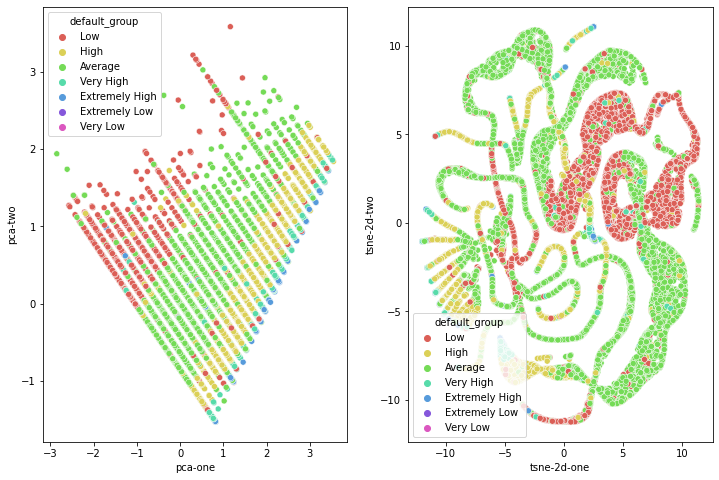

In [ ]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two", hue="default_group",
    palette=sns.color_palette("hls", n_colors=7),
    data=sr_features_num_std,
    legend="full",
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue="default_group",
    palette=sns.color_palette("hls", n_colors=7),
    data=sr_features_num_std,
    legend="full",
    ax=ax2
)
plt.show()

### *Explain whether PCA or t-SNE is better to use with this particular data set.*

PCA is linear and t-SNE is non-linear. In this case we don't know if the dimensions are linearily related to each other, therefore assuming it is linear can be dangerous and reduce accuracy. Looking at the graph, you can see that the t-SNE is better at creating seperate groups, but fails to put the correct datapoints from 'default_group' into these seperate groups. However, in the PCA plot it is much easier to see the where the default_groups datapoints form a group. 

Also, we are working with labeled data since we already know the features and the target. Therefore, we recommend using a PCA, since PCA outperforms t-SNE in labeled data.


# Question 4

(22 points)

### *Add the two columns you made with PCA to the dataset. Then pick a Decision Tree model and train a good model to predict the Probability of Default (`ProbabilityDefault`). It is not necessary to tune the hyperparameters (so the default settings are fine).*

In [46]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

In [47]:
sr_features_num_std = sr_features_num_std.drop(['tsne-2d-one', 'tsne-2d-two', 'default_group'] ,axis=1)
sr_tot_features_std = sr_features_num_std.join(sr_features_cat_std)

#Zip excluded due to previously mentioned reason
sr_tot_features_std = sr_tot_features_std.drop(['Zip'],axis=1)

#Impute missing values with the mean
sr_tot_features_std = sr_tot_features_std.fillna(sr_tot_features_std.mean())
sr_targets_std = sr_targets_std.fillna(sr_targets_std.mean())

For splitting the dataset in a training and test set, we use the 80/20 rule. This means we select 80% of our dataframe for training the model and 20% of our dataframe for testing the model.

In [48]:
SPLIT_SIZE = 0.2
COSTANT_SPLIT = 0

features_train,features_test,targets_train,targets_test=train_test_split(sr_tot_features_std,sr_targets_std,test_size=SPLIT_SIZE,random_state=COSTANT_SPLIT)

#Train a model and predict
clf = tree.DecisionTreeRegressor().fit(features_train, targets_train)
targets_pred = clf.predict(features_test)

### *Explain how well your model performs. Do you think the predictions are any good?*

In [85]:
#A function for the two performance metrics considered
def score_metrics(y_test, y_pred):

    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    print('The R-Squared is ' + str(round(r2,4)))
    print('The Root Mean Squared Error is ' + str(round(rmse,4)))

print('The Test Statistics on the test set:')
score_metrics(targets_test, targets_pred)

The Test Statistics on the test set:
The R-Squared is 0.2809
The Root Mean Squared Error is 0.6691


#### Interpretation
The two model performance metrics above are the the R-squared and the Root Mean Squared Error (RMSE). The R-squared shows that the model predictions do not fit the data to a high extend since the value is low with only 0.2809. The RMSE, preferably as low as possible, is the prediction error and is considered too high to classify the prediction as good.

# Question 5

(22 points)

### *This question turns on how to tune hyperparameters. Please compute what you consider the best choice for "splitter", "max_depth", and "min_samples_leaf" (jointly).*

Using GridSearch, the splitter, max_depth, and min_samples_leaf parameters of DecisionTreeRegressor are tweaked in order to find the best possible combination of the three. The choice has been made to do this to find the a maximum score for the performance metric R-squared. The GridSearch tuning algorithm uses, next to this R-squared score, a cross validation of 5. 

In [79]:
#Initialize GridSearch Parameters:
params={"splitter":["best","random"],
            "max_depth" : [3,4,5,6,7],
           "min_samples_leaf":[1,2,3,4,5,6]
           }

tuned_model = GridSearchCV(decision_tree,param_grid=params,scoring='r2',cv=5)
X = sr_tot_features_std
Y = sr_targets_std
tuned_model.fit(X,Y)
tuned_model.best_params_

{'max_depth': 5, 'min_samples_leaf': 6, 'splitter': 'best'}

In [86]:
#Re-estimated/train the decision tree regressor with the new Hyperparameters

tuned_tree= tree.DecisionTreeRegressor(**tuned_model.best_params_)
tuned_tree.fit(features_train,targets_train)
tuned_pred=tuned_tree.predict(features_test)

print('R-Squared score on the Training Data: '+ str(round(tuned_hyper_model.score(features_train,targets_train),4)))
print('The Test Statistics on the test set:')
score_metrics(targets_test, tuned_pred)

R-Squared score on the Training Data: 0.6653
The Test Statistics on the test set:
The R-Squared is 0.644
The Root Mean Squared Error is 0.4708


### *Does your hyperparameter tuning does lead to overfitting? Provide arguments.*

The hyperparameter tuning has led to a much better fit on the test data and a worse fit on the training data. The R-squared score of the model on the training set and the testing set do not differ much, meaning that our hyperparameter tuning did not led to overfitting.

### *Explain whether you consider the hyperparameter tuning useful (given amongst others the compute time, precision, other considerations, etc.).*

As explained before, the R-squared score improved significantly from 0.2809 to 0.644. Besides, the Root Mean Squared Error decreased from 0.6691 to 0.4708. Together with the fact that it did not let to overfitting, the tuning can be considered useful. However, tuning the hyperparameter took a lot of time when the larger lists were used. 

---